In [153]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import sqrt
from scipy.optimize import minimize
from bokeh.plotting import figure, show
from bokeh.models import Range1d
from bokeh.io import output_notebook
output_notebook()
import sys

stockdata = pd.read_csv('C:/Users/rm2019/Documents/Python Scripts/stock.csv', index_col='Date')

Loading BokehJS ...

In [185]:
temp_data = (stockdata / stockdata.shift(252)-1)
dndx = pd.to_datetime(temp_data.index)
data = pd.DataFrame(temp_data,columns=data.columns,index=dndx)

In [155]:
default_colors = [(165,0,38),(215,48,39),(244,109,67),(253,174,97),(254,224,144),(255,255,191),(224,243,248),(171,217,233),(116,173,209),(69,117,180),(49,54,149),(66,244,140),(255,0,255)]
default_colors = [default_colors[k] for k in [0,10,2,8,4,6,1,9,3,7,11,12]]

In [192]:
# Accepts a DataFrame or a Series of return data and products the corresponding
# cumulative return figures
def cum_growth(x):
    T0 = x.index[[0]] - (x.index[1] - x.index[0])
    if type(x) is pd.DataFrame:
        x0 = pd.DataFrame(1,columns=x.columns, index=T0)
    else:
        x0 = pd.Series(1,name=x.name, index=T0)
    x = x0.append(x+1).cumprod()
    return x

def print_portfolio(p):
    vals = 100.0 * p.sort_values(ascending=False)
    ndx = 0
    for v in vals.iteritems():
        if v[1] == 0:
            continue
        if ndx == 4:
            print('')
            ndx = 0 
        sys.stdout.write('  %4s: %5.1f%%'%v)
        ndx += 1
    print('')
    print('')
    print('Expected return: {:4.2f}%'.format(port_mean(p) * 100))
    print('Standard deviation: {:4.2f}%'.format(port_risk(p) *100))
    print('Maximum drawdown: {:4.2f}%'.format(sum(p * data.min()) *100))

def port_mean(p):
    return means.dot(p)

def port_risk(p):
    return sqrt(cmat.dot(p).dot(p))

def port_growth(p):
    return cum_growth(data[1:].dot(p))

In [193]:
means = data.mean()
cmat = data.cov()
stds = data.std()
syms = data.columns
maxret = means.max()
minret = means.min()
maxret_sym = means.idxmax()
minret_sym = means.idxmin()
maxvar_sym = stds.idxmax()
minvar_sym = stds.idxmin()
N = data.shape[1]
p_equal = np.full(N, 1.0/N)

In [190]:
print('Maximum return:   {}: {:+5.2f}% +/- {:4.2f}%'.format(maxret_sym,means[maxret_sym]*100,stds[maxret_sym]*100))
print('Maximum variance: {}: {:+5.2f}% +/- {:4.2f}%'.format(maxvar_sym,means[maxvar_sym]*100,stds[maxvar_sym]*100))
print('Minimum return:   {}: {:+5.2f}% +/- {:4.2f}%'.format(minret_sym,means[minret_sym]*100,stds[minret_sym]*100))
print('Minimum variance: {}: {:+5.2f}% +/- {:4.2f}%'.format(minvar_sym,means[minvar_sym]*100,stds[minvar_sym]*100))
print('Equal allocation:      {:+5.2f}% +/- {:4.2f}%'.format(port_mean(p_equal)*100,port_risk(p_equal)*100))
extremes = { maxret_sym, minret_sym, maxvar_sym, minvar_sym }

Maximum return:   NFLX: +86.24% +/- 108.48%
Maximum variance: NFLX: +86.24% +/- 108.48%
Minimum return:   XOM: +2.70% +/- 11.82%
Minimum variance: MCD: +12.10% +/- 11.53%
Equal allocation:      +29.52% +/- 14.02%


In [211]:
tx = data.index
tmp = cum_growth(data)
fig = figure(x_axis_type='datetime',y_axis_type='log',tools="pan,box_zoom,reset")
cndx = 0
for symb in extremes:
    fig.line(tx,tmp[symb][1:],legend=symb,color=default_colors[cndx],line_width=2)
    cndx += 1
for symb in cg_syms:
    if symb not in extremes:
        fig.line(tx,tmp[symb][1:],color=default_colors[cndx],alpha=0.75)
fig.line(tx,port_growth(p_equal),color='purple',legend='equal allocation',line_width=2)
fig.legend.orientation='vertical'
show(fig)

In [195]:
fig = figure(tools="pan,box_zoom,reset")
fig.circle(stds,means,size=5,color=default_colors[0])
fig.text(stds,means,syms,text_font_size='10px',x_offset=3,y_offset=-2)
fig.xaxis.axis_label='Standard deviation'
fig.yaxis.axis_label='Expected return'
show(fig)

In [196]:
n_pts = 50000
X = np.random.uniform(size=(n_pts,N+1))
X[:,0] = 0; X[:,-1] = 1
X[:,1:-1].sort(axis=1)
X = np.diff(X,axis=1)
X = pd.DataFrame(X, columns=data.columns)
means_X = X.dot(means)
stds_X = np.sqrt((X*X.dot(cmat)).sum(axis=1))
mc_minret = means_X.idxmin()
mc_maxret = means_X.idxmax()
mc_minrisk = stds_X.idxmin()
mc_maxrisk = stds_X.idxmax()

In [197]:
means_x_df = pd.DataFrame(means_X, columns=['mean']).rename_axis('portnum')
stds_x_df = pd.DataFrame(stds_X, columns=['std']).rename_axis('portnum')
temp_df = means_x_df.join(stds_x_df)

In [198]:
temp_df['mean_rank'] = temp_df['mean'].rank(ascending=1)
temp_df['std_rank'] = temp_df['std'].rank(ascending=0)
temp_df['total_rank'] = temp_df.mean_rank + temp_df.std_rank
optimal_portfolio_id = temp_df.total_rank.idxmax()

In [214]:
fig = figure(x_axis_type='datetime',y_axis_type='log',tools="pan,box_zoom,reset")
tmp = port_growth(X[:100].T)
for k in range(tmp.shape[1]):
    fig.line(tx,tmp.iloc[:,k],color=default_colors[5])
fig.line(tx,port_growth(X.iloc[means_X.idxmin()]),line_width=2,color=default_colors[3],legend='Lowest return')
fig.line(tx,port_growth(X.iloc[means_X.idxmax()]),line_width=2,color=default_colors[4],legend='Highest return')
fig.line(tx,port_growth(X.iloc[optimal_portfolio_id]),line_width=2,color=default_colors[11],legend='Optimal portfolio')
tmp = cum_growth(data[maxret_sym])
tmax = tmp.max()
fig.line(tmp.index,tmp.values,legend=maxret_sym,line_width=2,color=default_colors[0])
tmp = cum_growth(data[minret_sym])
tmin = tmp.min()
fig.line(tx,tmp.values,legend=minret_sym,line_width=2,color=default_colors[1])
fig.line(tx,port_growth(p_equal),legend='equal allocation',line_width=2,color=default_colors[2])
fig.y_range = Range1d(tmin/1.25,1.25*tmax)
fig.legend.orientation="vertical"
show(fig)

C:\Users\rm2019\AppData\Local\Continuum\anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 1238), ('y', 1239)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [215]:
fig = figure(tools="pan,box_zoom,reset")
fig.circle(stds_X,means_X,size=0.5,alpha=0.1,color=default_colors[0])
fig.circle(stds,means,size=5,color=default_colors[1])
fig.circle(port_risk(X.loc[mc_minrisk]),port_mean(X.loc[mc_minrisk]),size=8,color=default_colors[10],legend='Minimum risk')
fig.circle(port_risk(X.loc[mc_maxret]),port_mean(X.loc[mc_maxret]),size=8,color=default_colors[3],legend='Maximum return')
fig.circle(port_risk(X.loc[optimal_portfolio_id]),port_mean(X.loc[optimal_portfolio_id]),size=10,color=default_colors[11],legend='Optimal portfolio')
fig.text(stds,means,syms,text_font_size='10px',alpha=0.5,x_offset=3,y_offset=-2)
fig.xaxis.axis_label='Standard deviation'
fig.yaxis.axis_label='Expected return'
show(fig)

In [201]:
print("The following is the minimum risk portfolio:")
print("")
print_portfolio(X.loc[mc_minrisk])

The following is the minimum risk portfolio:

   MCD:  36.8%   DIS:  16.8%   LMT:  16.3%   DLR:  10.2%
  AAPL:   6.6%   XOM:   2.9%  MSFT:   2.7%    FB:   2.3%
  AMZN:   2.2%  TCEHY:   1.3%   JNJ:   1.1%  NFLX:   0.6%

Expected return: 16.30%
Standard deviation: 4.96%
Maximum drawdown: -16.01%


In [202]:
print("The following is the maximum return portfolio:")
print("")
print_portfolio(X.loc[mc_maxret])

The following is the maximum return portfolio:

  NFLX:  71.3%   JNJ:   7.0%   DLR:   6.7%  MSFT:   5.5%
   LMT:   3.2%  AAPL:   1.9%   MCD:   1.4%   DIS:   1.3%
    FB:   0.9%  AMZN:   0.6%   XOM:   0.2%  TCEHY:   0.0%

Expected return: 67.19%
Standard deviation: 76.65%
Maximum drawdown: -22.66%


In [203]:
print("The following is the optimal portfolio:")
print("")
print_portfolio(X.loc[optimal_portfolio_id])

The following is the optimal portfolio:

   DLR:  29.4%  AMZN:  21.4%  MSFT:  15.9%  AAPL:  10.6%
    FB:   6.3%  NFLX:   5.5%   DIS:   4.9%  TCEHY:   2.5%
   LMT:   1.6%   MCD:   0.8%   XOM:   0.6%   JNJ:   0.3%

Expected return: 31.88%
Standard deviation: 7.47%
Maximum drawdown: -21.73%


In [204]:
import seaborn as sns
cor = data.corr()

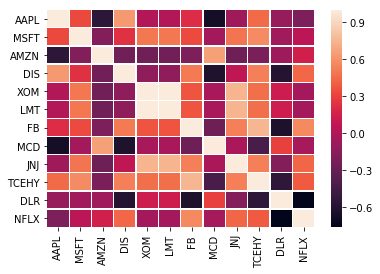

In [205]:
ax = sns.heatmap(cor,linewidth=.25)